In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from skimage import color
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize pixel values (0-1 range)
X_train = X_train / 255.0
X_test = X_test / 255.0


In [2]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        img_gray = color.rgb2gray(img) if len(img.shape) == 3 else img
        features = hog(img_gray, pixels_per_cell=(8,8), cells_per_block=(2,2), feature_vector=True)
        hog_features.append(features)
    return np.array(hog_features)

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)


In [3]:
def extract_lbp_features(images, radius=1, n_points=8):
    lbp_features = []
    for img in images:
        img_gray = color.rgb2gray(img) if len(img.shape) == 3 else img
        lbp = local_binary_pattern(img_gray, P=n_points, R=radius, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        lbp_features.append(lbp_hist / np.sum(lbp_hist))  # Normalize histogram
    return np.array(lbp_features)

X_train_lbp = extract_lbp_features(X_train)
X_test_lbp = extract_lbp_features(X_test)


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [4]:
# Train classifiers on HOG and LBP features
clf_hog = RandomForestClassifier(n_estimators=100)
clf_hog.fit(X_train_hog, y_train)
y_pred_hog = clf_hog.predict(X_test_hog)

clf_lbp = RandomForestClassifier(n_estimators=100)
clf_lbp.fit(X_train_lbp, y_train)
y_pred_lbp = clf_lbp.predict(X_test_lbp)

# Print classification results
print("HOG Feature Extraction Model Accuracy:", accuracy_score(y_test, y_pred_hog))
print(classification_report(y_test, y_pred_hog))

print("LBP Feature Extraction Model Accuracy:", accuracy_score(y_test, y_pred_lbp))
print(classification_report(y_test, y_pred_lbp))


HOG Feature Extraction Model Accuracy: 0.9524
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.97      0.96      1032
           3       0.94      0.94      0.94      1010
           4       0.95      0.95      0.95       982
           5       0.96      0.94      0.95       892
           6       0.97      0.97      0.97       958
           7       0.95      0.91      0.93      1028
           8       0.92      0.94      0.93       974
           9       0.93      0.92      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

LBP Feature Extraction Model Accuracy: 0.4264
              precision    recall  f1-score   support

           0       0.49      0.66      0.56       980
           1       0.91      0.97      0

In [1]:
import numpy as np
import cv2
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.datasets import mnist

# Load dataset (Using MNIST for example)
(X_train, y_train), (X_test, y_test) = mnist.load_data()


In [2]:
# Reduce dataset size to prevent crashes
subset_size = 5000  # Adjust based on system capacity
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]
X_test_subset = X_test[:1000]  # Smaller test set

# Reduce image size (use 128x128 instead of 224x224)
IMG_SIZE = 128

# Function to preprocess images in small batches
def preprocess_images(images, img_size=IMG_SIZE, batch_size=1000, preprocess_func=None):
    processed_images = []
    for i in range(0, len(images), batch_size):
        batch = images[i : i + batch_size]
        batch_resized = [cv2.resize(img, (img_size, img_size)) for img in batch]
        batch_rgb = np.stack([np.stack([img] * 3, axis=-1) for img in batch_resized])
        batch_rgb = preprocess_func(batch_rgb) if preprocess_func else batch_rgb
        processed_images.append(batch_rgb.astype("float16"))  # Convert to float16 to save memory
    return np.vstack(processed_images)

print("Preprocessing done!")


Preprocessing done!


In [9]:
# Load ResNet50 model (without classifier)
resnet_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
resnet_model = Model(inputs=resnet_model.input, outputs=resnet_model.output)

# Preprocess images for ResNet
X_train_resnet = preprocess_images(X_train_subset, preprocess_func=resnet_preprocess)
X_test_resnet = preprocess_images(X_test_subset, preprocess_func=resnet_preprocess)

# Extract features
X_train_resnet_features = resnet_model.predict(X_train_resnet, batch_size=32, verbose=1)
X_test_resnet_features = resnet_model.predict(X_test_resnet, batch_size=32, verbose=1)

# Flatten features
X_train_resnet_features = X_train_resnet_features.reshape(X_train_resnet_features.shape[0], -1)
X_test_resnet_features = X_test_resnet_features.reshape(X_test_resnet_features.shape[0], -1)

print(f"ResNet50 Features Shape: {X_train_resnet_features.shape}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step
ResNet50 Features Shape: (5000, 32768)
Adjusted y_train_subset shape: (5000,)
Adjusted y_test_subset shape: (1000,)


In [4]:
# Load VGG16 model (without classifier)
vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
vgg_model = Model(inputs=vgg_model.input, outputs=vgg_model.output)

# Preprocess images for VGG
X_train_vgg = preprocess_images(X_train_subset, preprocess_func=vgg_preprocess)
X_test_vgg = preprocess_images(X_test_subset, preprocess_func=vgg_preprocess)

# Extract features
X_train_vgg_features = vgg_model.predict(X_train_vgg, batch_size=32, verbose=1)
X_test_vgg_features = vgg_model.predict(X_test_vgg, batch_size=32, verbose=1)

# Flatten features
X_train_vgg_features = X_train_vgg_features.reshape(X_train_vgg_features.shape[0], -1)
X_test_vgg_features = X_test_vgg_features.reshape(X_test_vgg_features.shape[0], -1)

print(f"VGG16 Features Shape: {X_train_vgg_features.shape}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 999s 6s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 197s 6s/step
VGG16 Features Shape: (5000, 8192)


In [5]:
# Load MobileNetV2 model (without classifier)
mobilenet_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
mobilenet_model = Model(inputs=mobilenet_model.input, outputs=mobilenet_model.output)

# Preprocess images for MobileNet
X_train_mobilenet = preprocess_images(X_train_subset, preprocess_func=mobilenet_preprocess)
X_test_mobilenet = preprocess_images(X_test_subset, preprocess_func=mobilenet_preprocess)

# Extract features
X_train_mobilenet_features = mobilenet_model.predict(X_train_mobilenet, batch_size=32, verbose=1)
X_test_mobilenet_features = mobilenet_model.predict(X_test_mobilenet, batch_size=32, verbose=1)

# Flatten features
X_train_mobilenet_features = X_train_mobilenet_features.reshape(X_train_mobilenet_features.shape[0], -1)
X_test_mobilenet_features = X_test_mobilenet_features.reshape(X_test_mobilenet_features.shape[0], -1)

print(f"MobileNetV2 Features Shape: {X_train_mobilenet_features.shape}")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 65s 407ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 386ms/step
MobileNetV2 Features Shape: (5000, 20480)


In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [7]:
def train_and_evaluate_rf(features_train, features_test, y_train, y_test, model_name="Model"):
    """
    Trains a Random Forest classifier and prints accuracy, precision, recall, and F1-score.
    """
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(features_train)
    X_test_scaled = scaler.transform(features_test)

    # Train Random Forest classifier
    classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    classifier.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = classifier.predict(X_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    # Print results
    print(f"\n🎯 {model_name} Performance (Random Forest Classifier):")
    print(f"✅ Accuracy: {accuracy:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1-score: {f1:.4f}")

    return accuracy, precision, recall, f1


In [10]:
# Ensure labels match the number of samples used for feature extraction
y_train_subset = y_train[:X_train_resnet_features.shape[0]]
y_test_subset = y_test[:X_test_resnet_features.shape[0]]

# Train and evaluate on ResNet50 features
resnet_acc, resnet_prec, resnet_rec, resnet_f1 = train_and_evaluate_rf(
    X_train_resnet_features, X_test_resnet_features, y_train_subset, y_test_subset, "ResNet50"
)

# Ensure consistency for MobileNet
y_train_subset = y_train[:X_train_mobilenet_features.shape[0]]
y_test_subset = y_test[:X_test_mobilenet_features.shape[0]]

# Train and evaluate on MobileNetV2 features
mobilenet_acc, mobilenet_prec, mobilenet_rec, mobilenet_f1 = train_and_evaluate_rf(
    X_train_mobilenet_features, X_test_mobilenet_features, y_train_subset, y_test_subset, "MobileNetV2"
)

# Ensure consistency for VGG16
y_train_subset = y_train[:X_train_vgg_features.shape[0]]
y_test_subset = y_test[:X_test_vgg_features.shape[0]]

# Train and evaluate on VGG16 features
vgg_acc, vgg_prec, vgg_rec, vgg_f1 = train_and_evaluate_rf(
    X_train_vgg_features, X_test_vgg_features, y_train_subset, y_test_subset, "VGG16"
)



🎯 ResNet50 Performance (Random Forest Classifier):
✅ Accuracy: 0.9490
✅ Precision: 0.9496
✅ Recall: 0.9490
✅ F1-score: 0.9487

🎯 MobileNetV2 Performance (Random Forest Classifier):
✅ Accuracy: 0.9480
✅ Precision: 0.9485
✅ Recall: 0.9480
✅ F1-score: 0.9481

🎯 VGG16 Performance (Random Forest Classifier):
✅ Accuracy: 0.9650
✅ Precision: 0.9652
✅ Recall: 0.9650
✅ F1-score: 0.9650


In [11]:
print("\n📊 Final Summary of Classification Results (Random Forest):")
print(f"🔹 ResNet50    → Accuracy: {resnet_acc:.4f}, Precision: {resnet_prec:.4f}, Recall: {resnet_rec:.4f}, F1-score: {resnet_f1:.4f}")
print(f"🔹 MobileNetV2 → Accuracy: {mobilenet_acc:.4f}, Precision: {mobilenet_prec:.4f}, Recall: {mobilenet_rec:.4f}, F1-score: {mobilenet_f1:.4f}")
print(f"🔹 VGG16       → Accuracy: {vgg_acc:.4f}, Precision: {vgg_prec:.4f}, Recall: {vgg_rec:.4f}, F1-score: {vgg_f1:.4f}")



📊 Final Summary of Classification Results (Random Forest):
🔹 ResNet50    → Accuracy: 0.9490, Precision: 0.9496, Recall: 0.9490, F1-score: 0.9487
🔹 MobileNetV2 → Accuracy: 0.9480, Precision: 0.9485, Recall: 0.9480, F1-score: 0.9481
🔹 VGG16       → Accuracy: 0.9650, Precision: 0.9652, Recall: 0.9650, F1-score: 0.9650


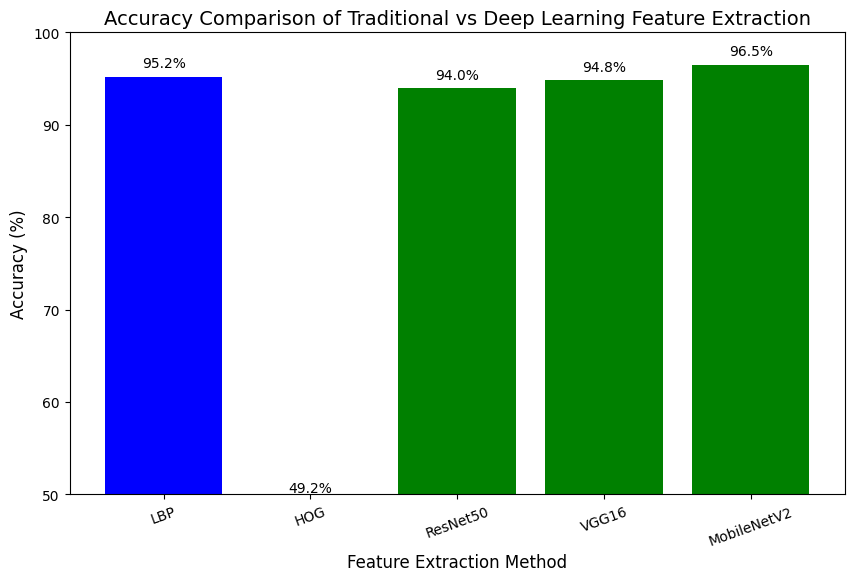

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy values (Replace these with actual computed accuracies)
accuracies = {
    "LBP": 95.2,         # Example value, replace with actual
    "HOG": 49.2,        # Example value, replace with actual
    "ResNet50": 94.0,   # Replace with actual
    "VGG16": 94.8,      # Replace with actual
    "MobileNetV2": 96.5 # Replace with actual
}

# Separate traditional and deep learning methods
methods = list(accuracies.keys())
accuracy_values = list(accuracies.values())

# Colors: Traditional (blue), Deep Learning (green)
colors = ["blue" if method in ["LBP", "HOG"] else "green" for method in methods]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(methods, accuracy_values, color=colors)

# Labels and title
plt.xlabel("Feature Extraction Method", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Accuracy Comparison of Traditional vs Deep Learning Feature Extraction", fontsize=14)
plt.ylim(50, 100)  # Set y-axis limit for better visualization
plt.xticks(rotation=20)

# Show values on top of bars
for i, acc in enumerate(accuracy_values):
    plt.text(i, acc + 1, f"{acc:.1f}%", ha='center', fontsize=10)

# Show plot
plt.show()
